## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left or right breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **prediction_id** - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

In [1]:
import pandas as pd
from itables import init_notebook_mode

In [2]:
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [51]:
dataset_dir = "../Datasets/Originals"
train_dataset = pd.read_csv('../train.csv')
test_dataset = pd.read_csv('../test.csv')

train_dataset


site_id  patient_id    image_id laterality view   age  cancer  biopsy   
0            2       10006   462822612          L   CC  61.0       0       0  \
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
43739        1        9973  1729524723          R  MLO  43.0       0       0   
43740        1        9989    63473691          L  MLO  60.0       0       0   
43741        1        9989  1078943060          L   CC  60.0       0       0   
43742        1        9989   398038886          R  MLO  60.0       0       0   
43743        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0             0     NaN        0     NaN          29                    False  
1             0     NaN        0     NaN          29                    False  
2             0     NaN        0     NaN          29                    False  
3             0     NaN        0     NaN          29                    False  
4             0     0.0        0     NaN          21                     True  
...         ...     ...      ...     ...         ...                      ...  
43739         0     1.0        0       C          49                    False  
43740         0     NaN        0       C         216                    False  
43741         0     NaN        0       C         216                    False  
43742         0     0.0        0       C         216                     True  
43743         0     0.0        0       C         216                     True  

[43744 rows x 14 columns]

In [52]:
train_neg_samples_cnt, train_pos_samples_cnt = train_dataset['cancer'].value_counts()
test_neg_samples_cnt, test_pos_samples_cnt = test_dataset['cancer'].value_counts()

print(f"Train dataset: {train_neg_samples_cnt} negative samples and {train_pos_samples_cnt} positive samples")
print(f"Test dataset: {test_neg_samples_cnt} negative samples and {test_pos_samples_cnt} positive samples")

Train dataset: 42778 negative samples and 966 positive samples
Test dataset: 10770 negative samples and 192 positive samples


In [53]:
# build dataset paths
from pathlib import Path

def build_image_path(image_id: str) -> str:
    return Path(dataset_dir, str(image_id) + '.png').resolve()

train_dataset['image_path'] = train_dataset['image_id'].apply(build_image_path, convert_dtype=str)
test_dataset['image_path'] = test_dataset['image_id'].apply(build_image_path, convert_dtype=str)

In [54]:
# split dataset into train and valdation

from sklearn.model_selection import train_test_split

train_dataset_df, val_dataset_df = train_test_split(train_dataset, test_size=0.2, random_state=666, stratify=train_dataset['cancer'])


# split train dataset into negative and positive samples
train_neg_df = train_dataset_df[train_dataset_df['cancer'] == 0]
train_pos_df = train_dataset_df[train_dataset_df['cancer'] == 1]

# split test dataset into negative and positive samples
val_neg_df = val_dataset_df[val_dataset_df['cancer'] == 0]
val_pos_df = val_dataset_df[val_dataset_df['cancer'] == 1]


# dataset informations

print(f"Train dataset: {len(train_dataset_df)} samples")
print(f"Validation dataset: {len(val_dataset_df)} samples")

print(f"Train dataset: {len(train_neg_df)} negative samples and {len(train_pos_df)} positive samples")
print(f"Validation dataset: {len(val_neg_df)} negative samples and {len(val_pos_df)} positive samples")

Train dataset: 34995 samples
Validation dataset: 8749 samples
Train dataset: 34222 negative samples and 773 positive samples
Validation dataset: 8556 negative samples and 193 positive samples


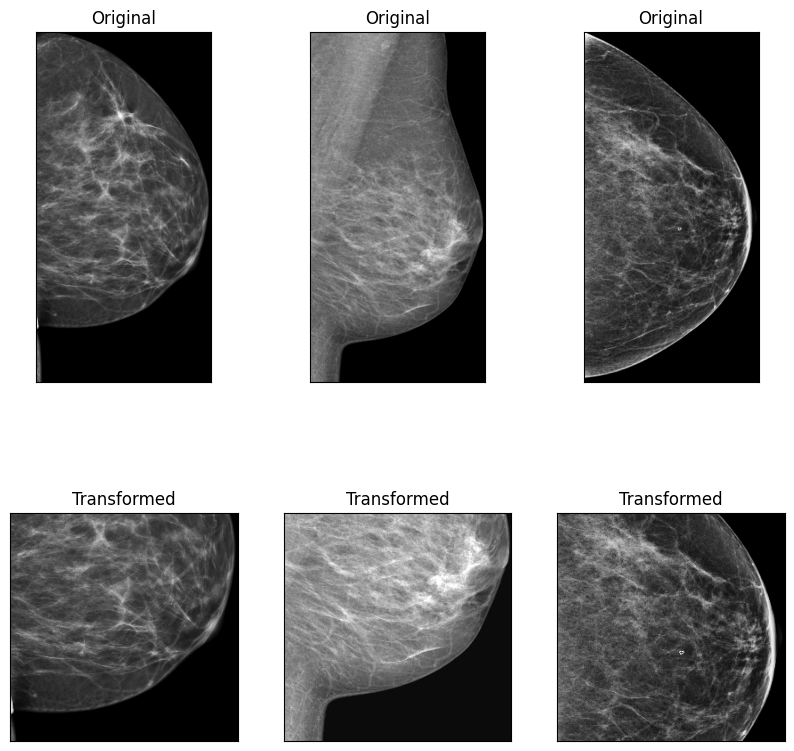

In [55]:
import random

import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

random.seed(666)

def read_image(image_path: str) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)


transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])


# Show normal and transformed images
ncols = 3
fig, axes = plt.subplots(nrows = 2, ncols = ncols, figsize = (10, 10), subplot_kw={'xticks':[], 'yticks':[]})
img_index = 0
for i, ax in enumerate(axes.flat):
    img = read_image(train_neg_df.iloc[img_index]['image_path'])
    if i <= ncols-1:
      ax.imshow(img)
      ax.set_title('Original')
      if img_index == ncols-1:
        img_index = 0
      else:
        img_index += 1
    else:
      ax.imshow(transform(image=img)['image'])
      ax.set_title('Transformed')
      img_index += 1
       
plt.show()

